# Assignment 2: exercise 3

## Tic-tac-toe with post-decision states

In [1]:
import gym
from gym import spaces
import matplotlib
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
import matplotlib.pyplot as plt
from io import StringIO


if "../" not in sys.path:
    sys.path.append("../")

matplotlib.style.use('ggplot')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def mapping_function(board):
    board = np.array(board).ravel()
    state = 0
    for i in range(len(board)):
        state += 3**i * board[i]
    return state


def check_row(board, player):
    for i in range(3):
        if board[i][0] == board[i][1] == board[i][2] == player:
            return True
    return False


def check_column(board, player):
    for j in range(3):
        if board[0][j] == board[1][j] == board[2][j] == player:
            return True
    return False


def check_diagonal(board, player):
    return board[0][0] == board[1][1] == board[2][2] == player or board[0][2] == board[1][1] == board[2][0] == player


def check_win(board, player):
    return check_column(board, player) or check_row(board, player) or check_diagonal(board, player)


def not_valid_actions(env, board):
    board = np.array(board)
    nv_act = []
    x = np.argwhere(board != 0)
    for e in x:
        e = tuple(e)
        nv_act.append(env.actions.index(e))
    return nv_act


def valid_actions(env, board):
    board = np.array(board)
    v_act = []
    x = np.argwhere(board == 0)
    for e in x:
        e = tuple(e)
        v_act.append(env.actions.index(e))
    return v_act


def count_zeros(board):
    c = 0
    for i in range(len(board[0])):
        for j in range(len(board[1])):
            if board[i][j] == 0:
                c += 1
    return c


class TicTacToe(gym.Env):

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        # State and action spaces
        self.shape = (3, 3)
        nS = np.prod(self.shape)
        nA = 9
        self.action_space = spaces.Discrete(nA)
        self.observation_space = spaces.MultiDiscrete(nS)

        # Available actions

        self.actions = []
        for s1 in range(self.shape[0]):
            for s2 in range(self.shape[1]):
                cross = (s1, s2)
                self.actions.append(cross)

        self.reset()

    def reset(self):
        self.board = np.zeros(self.shape, dtype=int)
        self.state = mapping_function(self.board)
        self.x_turns = 0
        self.o_turns = 0
        return self.state

    def step(self, action):
        a = self.actions[action]
        assert self.board[a] == 0

        # Obtain new cross

        self.board[a] = 2
        self.x_turns += 1

        # Get reward and terminal

        self.win = check_win(self.board, 2)
        self.loss = check_win(self.board, 1)

        is_done = self.win or self.loss or self.x_turns == 5

        if self.win:
            reward = 1
        elif self.loss:
            reward = -1
        else:
            reward = 0

        self.state = mapping_function(self.board)

        return self.state, reward, is_done, _

    def opponent_step(self, action):
        a = self.actions[action]
        assert self.board[a] == 0

        # Obtain new 'o'

        self.board[a] = 1
        self.o_turns += 1

        self.win = check_win(self.board, 2)
        self.loss = check_win(self.board, 1)

        is_done = self.win or self.loss or self.o_turns == 4

        if self.win:
            reward = 1
        elif self.loss:
            reward = -1
        else:
            reward = 0

        self.state = mapping_function(self.board)

        return self.state, reward, is_done, _

    def render(self, mode='human', close=False):
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        outfile.write("\n")
        for s1 in range(0, self.shape[0], 1):
            for s2 in range(self.shape[1]):
                position = (s1,s2)
                if self.board[position] == 0:
                    output = " - "
                elif self.board[position] == 1:
                    output = " o "
                else:
                    output = " x "

                if position[1] == 0:
                    output = output.lstrip() 
                if position[1] == self.shape[1] - 1:
                    output = output.rstrip() 
                    output += "\n"

                outfile.write(output)
        outfile.write("\n")

In [3]:
env = TicTacToe()

In [25]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):

    nA = env.action_space.n
    V = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)

    wins = 0
    losses = 0
    draws = 0

    # Loop over episodes
    for i in range(num_episodes):
        # Print every 100 episodes.
        if (i + 1) % 100 == 0 and i != num_episodes - 1:
            print("\rEpisode {}/{}.".format(i + 1, num_episodes), end="")
            if (i + 1) % num_episodes == 0:
                print("\n")
            sys.stdout.flush()

        state = env.reset()
        player_action = np.random.choice(np.argwhere(V[state] == np.amax(V[state])).ravel())
        post_decision_state, _, _, _ = env.step(player_action)
        random_action = valid_actions(env, env.board)[np.random.randint(len(valid_actions(env, env.board)))]
        next_state, _, done, _ = env.opponent_step(random_action)
        if i > num_episodes - 5:
            env.render()
        t = 2
        while not done:
            rs = {}
            for a in valid_actions(env, env.board):
                post_decision_board = env.board.copy()
                b = a
                a = env.actions[a]
                post_decision_board[a] = 2
                rs[b] = discount_factor * V[next_state][b]
                if count_zeros(post_decision_board) > 0:
                    for ra in valid_actions(env, post_decision_board):
                        next_board = post_decision_board.copy()
                        ra = env.actions[ra]
                        next_board[ra] = 1
                        if check_win(next_board, 2):
                            rs[b] += 1./len(valid_actions(env, post_decision_board))
                        elif check_win(next_board, 1):
                            rs[b] += -1./len(valid_actions(env, post_decision_board))

            max_a = max(rs, key=rs.get)

            action_probs = np.ones(nA) * epsilon / nA
            for e in not_valid_actions(env, env.board):
                action_probs[e] = 0
            action_probs = action_probs * nA / (nA - len(not_valid_actions(env, env.board)))
            best_action = max_a
            action_probs[best_action] += (1. - epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            v = max(rs.values())
            post_decision_state, reward, done, _ = env.step(action)
            t += 1
            if i > num_episodes - 5:
                env.render()
            V[post_decision_state] = (1 - alpha) * V[post_decision_state] + alpha * v

            if not done:
                random_action = valid_actions(env, env.board)[np.random.randint(len(valid_actions(env, env.board)))]
                next_state, reward_opponent, done, _ = env.opponent_step(random_action)
                t += 1
                if i > num_episodes - 5:
                    env.render()

            # Update statistics
            episode_rewards[i] += reward + reward_opponent
            episode_lengths[i] = t

        if env.win:
            wins += 1
        elif env.loss:
            losses += 1
        elif not(env.win) and not(env.loss):
            draws += 1

        if i > num_episodes - 5:
            print('Number of turns:', env.x_turns + env.o_turns)
            if reward == 1:
                print('Win')
            elif reward == -1:
                print('Loss')
            else:
                print('Draw')

    print(20*'-')
    print('Wins:', wins)
    print('Losses:', losses)
    print('Draws:', draws)
    print(20*'-')
    
    size_of_groups = [wins, draws, losses]
    labels = ['Wins', 'Draws', 'Losses']
    explode = (0.05, 0.05, 0.05)
    
    # Create a pieplot
    pie = plt.figure(figsize=(10, 5))
    title = "Wins, Draws and Losses"
    
    plt.title(title)
    plt.pie(size_of_groups, labels=labels,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
    
    # add a circle at the center to transform it in a donut chart
    my_circle = plt.Circle( (0,0), 0.7, color='white')
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.savefig(title+".png")
    plt.show(pie)
    return V, episode_rewards, episode_lengths

Episode 1900/2000.
-  -  x
-  o  -
-  -  -


x  -  x
-  o  -
-  -  -


x  -  x
-  o  -
-  o  -


x  x  x
-  o  -
-  o  -

Number of turns: 5
Win

-  -  o
-  -  -
x  -  -


x  -  o
-  -  -
x  -  -


x  -  o
o  -  -
x  -  -


x  x  o
o  -  -
x  -  -


x  x  o
o  -  -
x  o  -


x  x  o
o  x  -
x  o  -


x  x  o
o  x  -
x  o  o

Number of turns: 8
Draw

-  -  -
-  o  -
-  x  -


x  -  -
-  o  -
-  x  -


x  o  -
-  o  -
-  x  -


x  o  x
-  o  -
-  x  -


x  o  x
o  o  -
-  x  -


x  o  x
o  o  x
-  x  -


x  o  x
o  o  x
o  x  -

Number of turns: 8
Draw

-  -  o
x  -  -
-  -  -


-  -  o
x  -  -
x  -  -


-  -  o
x  -  -
x  -  o


x  -  o
x  -  -
x  -  o

Number of turns: 5
Win
--------------------
Wins: 1558
Losses: 62
Draws: 380
--------------------


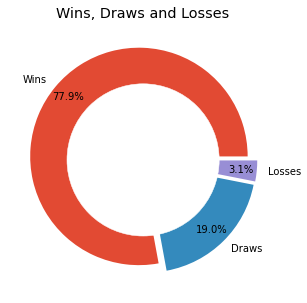

In [26]:
n_episodes = 2000
V, episode_rewards, episode_lengths = q_learning(env, n_episodes)

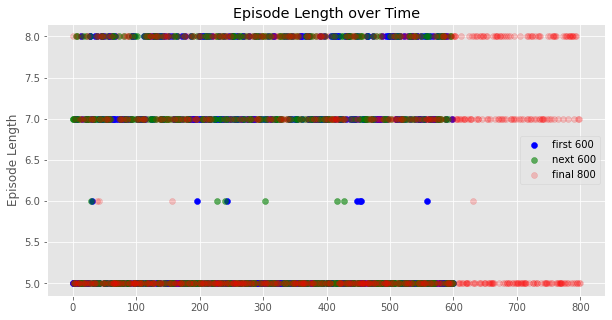

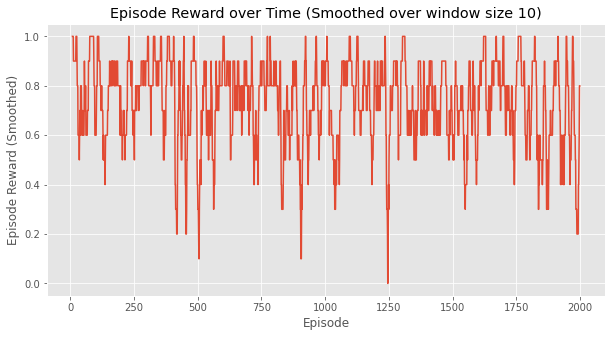

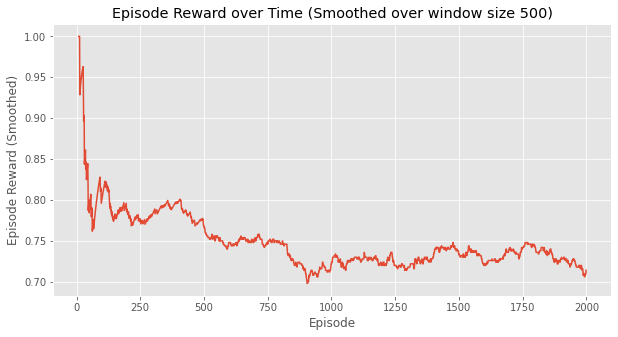

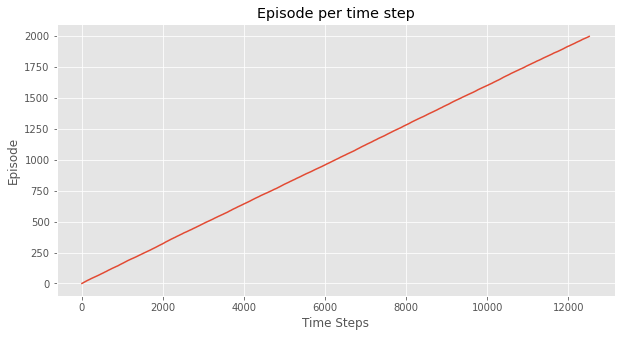

In [9]:
# Plot the episode length over time
fig1 = plt.figure(figsize=(10, 5))
plt.scatter(np.arange(600), episode_lengths[:600], alpha=1, label='first 600', color='blue')
plt.scatter(np.arange(600), episode_lengths[600:1200], alpha=.6, label='next 600', color='green')
plt.scatter(np.arange(800), episode_lengths[1200:2000], alpha=.2, label='final 800', color='red')
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.savefig("Episode Length over Time"+".png")
plt.legend()
plt.show(fig1)

# Plot the episode reward over time
fig2 = plt.figure(figsize=(10, 5))
rewards_smoothed = pd.Series(episode_rewards).rolling(10, min_periods=10).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time (Smoothed over window size {})".format(10))
plt.savefig("Episode Reward over Time"+".png")

plt.show(fig2)

# Plot the episode reward over time
fig3 = plt.figure(figsize=(10, 5))
rewards_smoothed = pd.Series(episode_rewards).rolling(500, min_periods=10).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time (Smoothed over window size {})".format(500))
plt.savefig("Episode Reward over Time"+".png")

plt.show(fig3)

# Plot time steps and episode number
fig4 = plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)))
plt.xlabel("Time Steps")
plt.ylabel("Episode")
plt.title("Episode per time step")
plt.savefig("Episode per time step"+".png")
plt.show(fig4)